In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, Adagrad
from itertools import product


### Data processing and validation functions:

In [2]:
from data_processing import process_data

REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('palm_oil_data/production_good.csv')
rainfall = pd.read_csv('palm_oil_data/rainfall_good.csv')
area = pd.read_csv('palm_oil_data/area_good.csv')

RAINFALL_LAGS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
PRODUCTION_LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
ts = DATA['Johor'][1]
dates = DATA['Johor'][0].index
DATA['Johor'][0].columns

Index(['Johor_Month', 'Johor_Rainfall_13', 'Johor_Rainfall_14',
       'Johor_Rainfall_15', 'Johor_Rainfall_16', 'Johor_Rainfall_17',
       'Johor_Rainfall_18', 'Johor_Rainfall_19', 'Johor_Rainfall_20',
       'Johor_Rainfall_21', 'Johor_Rainfall_22', 'Johor_Rainfall_23',
       'Johor_Rainfall_24', 'Johor_Rainfall_25', 'Johor_Rainfall_26',
       'Johor_Production_1', 'Johor_Production_2', 'Johor_Production_3',
       'Johor_Production_4', 'Johor_Production_5', 'Johor_Production_6',
       'Johor_Production_7', 'Johor_Production_8', 'Johor_Production_9',
       'Johor_Production_10', 'Johor_Production_11', 'Johor_Production_12',
       'Johor_Production_13'],
      dtype='object')

In [4]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [5]:
from metrics import wmape, rmse

# function to validate LSTM and RNN:
def val_lstm_rnn(train_X, train_y, val_X, val_y, epochs, units, dropout_probs, activations, model_name="LSTM"):
    train_x = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_x = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

    val_y = np.concatenate((val_X, val_y), axis=1)
    val_y = scaler.inverse_transform(val_y)
    val_y = val_y[:,-1]

    best_model, best_rmse, best_wmape, best_params = None, -np.Inf, -np.Inf, None
    for units, dropout, activation, epoch in product(units, dropout_probs, activations, epochs):
        
        model = Sequential()

        if model_name == "LSTM":
            model.add(LSTM(units, input_shape=(train_x.shape[1], train_x.shape[2])))
        else:
            model.add(SimpleRNN(units, input_shape=(train_x.shape[1], train_x.shape[2])))


        model.add(Dropout(dropout))
        model.add(Dense(1, activation=activation))
        model.compile(loss='mean_squared_error', optimizer='adam')

        model.fit(train_x, train_y, 
                epochs=epoch, batch_size=64, 
                validation_data=(test_x, val_y), 
                verbose=0, shuffle=False)

        # make a prediction
        yhat_train = model.predict(train_x)
        yhat_train = np.concatenate((train_X, yhat_train), axis=1)
        yhat_train = scaler.inverse_transform(yhat_train)
        yhat_train = yhat_train[:,-1]

        yhat = model.predict(test_x)
        yhat = np.concatenate((test_X, yhat), axis=1)
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat[:,-1]

        cur_rmse, cur_wmape = rmse(val_y, yhat), wmape(val_y, yhat)
        if abs(rmse(val_y, yhat)) < abs(best_rmse):
            best_model = model
            best_rmse = cur_rmse
            best_wmape = cur_wmape
            best_params = [units, dropout, activation, epoch]

    print("Best hyper-parameters:")
    print("units: %i" % best_params[0])
    print("dropout_prob: %f" % best_params[1])
    print("activation: %s" % best_params[2])
    print("epoch num: %s" % best_params[3])

    
    print("\nTrain data RMSE: %f; Train data WMAPE: %f" % (best_rmse, best_wmape))


In [6]:
def forecast_plot(model, train_X, test_X, test_y):
    # make a prediction
    yhat = model.predict(test_X)
    yhat[yhat<0] = 0
    yhat_train = model.predict(train_X)
    yhat_train[yhat_train<0] = 0

    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

    # invert scaling for training
    inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,-1]


    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]


    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    print("Actual data: ", inv_y)
    print("Forecast: ",inv_yhat)

    # plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
    plt.plot(DATA['Johor'][1], label="Actual data")
    plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
    plt.legend()

## LSTM

In [10]:
VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

val = train[-VALIDATION_SHIFT:, :]
train = train[:-VALIDATION_SHIFT, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]


In [12]:
dropout = [0.2]
activations=['relu', 'sigmoid', 'tanh']

# Looking for the best parameters
val_lstm_rnn(train_X, train_y, val_X, val_y,
              epochs=[200],
              units=[5, 20, 100],
              dropout_probs=[0.02, 0.2, 0.4],
              activations=['relu', 'sigmoid', 'tanh'], 
              model_name="LSTM")

Best hyper-parameters:
units: 100
dropout_prob: 0.020000
activation: relu
epoch num: 200

Train data RMSE: 21.276522; Train data WMAPE: 0.076318


Epoch 1/200
4/4 - 2s - loss: 0.1794 - val_loss: 0.1644 - 2s/epoch - 579ms/step
Epoch 2/200
4/4 - 0s - loss: 0.0827 - val_loss: 0.0722 - 34ms/epoch - 8ms/step
Epoch 3/200
4/4 - 0s - loss: 0.0374 - val_loss: 0.0313 - 35ms/epoch - 9ms/step
Epoch 4/200
4/4 - 0s - loss: 0.0346 - val_loss: 0.0236 - 38ms/epoch - 9ms/step
Epoch 5/200
4/4 - 0s - loss: 0.0436 - val_loss: 0.0225 - 41ms/epoch - 10ms/step
Epoch 6/200
4/4 - 0s - loss: 0.0420 - val_loss: 0.0207 - 41ms/epoch - 10ms/step
Epoch 7/200
4/4 - 0s - loss: 0.0343 - val_loss: 0.0232 - 42ms/epoch - 10ms/step
Epoch 8/200
4/4 - 0s - loss: 0.0291 - val_loss: 0.0292 - 44ms/epoch - 11ms/step
Epoch 9/200
4/4 - 0s - loss: 0.0279 - val_loss: 0.0331 - 43ms/epoch - 11ms/step
Epoch 10/200
4/4 - 0s - loss: 0.0274 - val_loss: 0.0319 - 48ms/epoch - 12ms/step
Epoch 11/200
4/4 - 0s - loss: 0.0256 - val_loss: 0.0268 - 50ms/epoch - 12ms/step
Epoch 12/200
4/4 - 0s - loss: 0.0236 - val_loss: 0.0212 - 47ms/epoch - 12ms/step
Epoch 13/200
4/4 - 0s - loss: 0.0225 - va

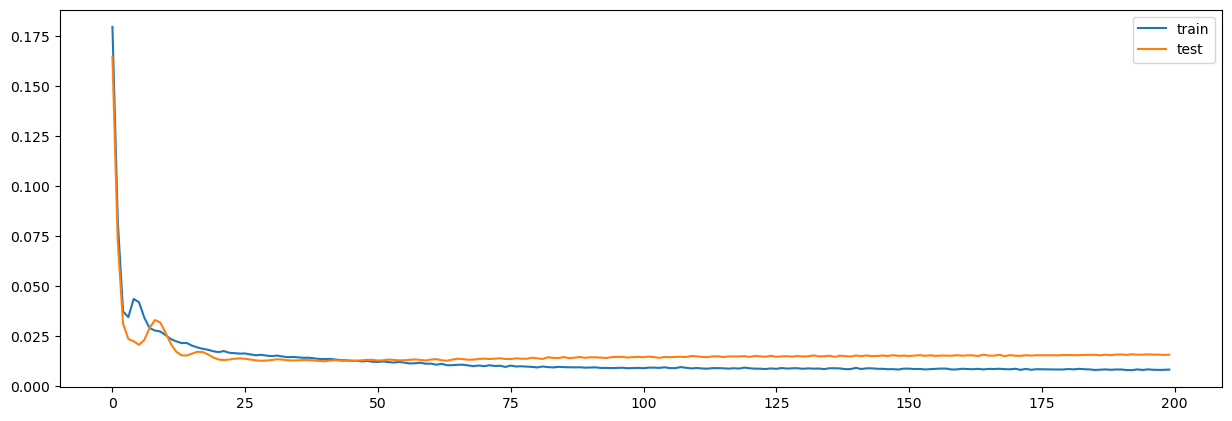

In [21]:

units = 100
dropout_probs = 0.02 
activation = 'relu'

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]
EPOCHS = 200

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

lstm = Sequential()
lstm.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm.add(Dropout(dropout_probs))
lstm.add(Dense(1, activation='relu'))
# model.compile(loss='mae', optimizer=optimizer)
lstm.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = lstm.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


Test RMSE: 23.826
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [283.97218338 253.63697509 232.75099594 220.46272877 212.60061664
 218.44639797 215.98178227 229.94956388 238.95298094 218.5427643
 283.87363218 307.82981786]


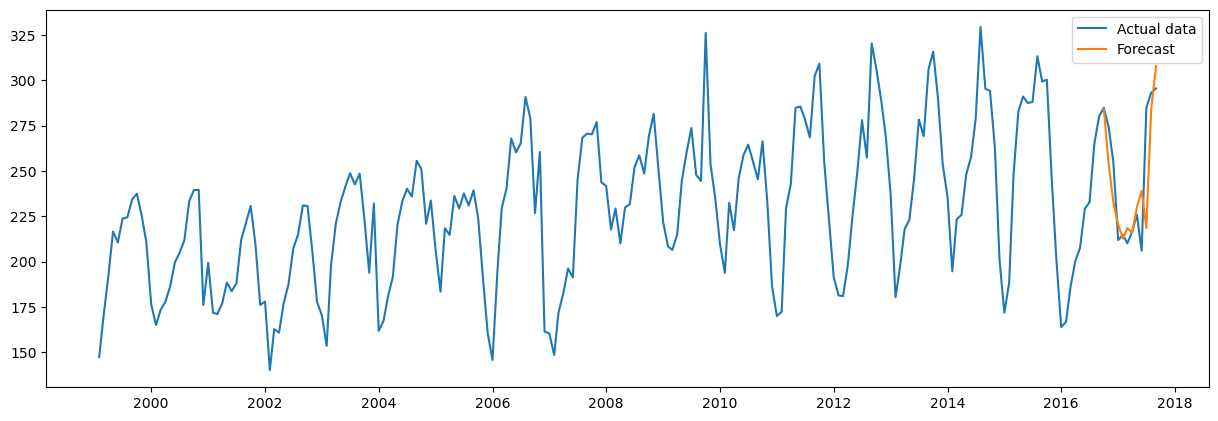

In [22]:
forecast_plot(lstm, train_X, test_X, test_y)

## RNN

In [15]:
train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

val = train[-VALIDATION_SHIFT:, :]
train = train[:-VALIDATION_SHIFT, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]

val_lstm_rnn(train_X, train_y, val_X, val_y,
              epochs=[200, 500],
              units=[10, 50, 400],
              dropout_probs=[0.02, 0.2, 0.5],
              activations=['relu', 'sigmoid', 'tanh'], 
              model_name="RNN")

Best hyper-parameters:
units: 10
dropout_prob: 0.020000
activation: relu
epoch num: 200

Train data RMSE: 17.175956; Train data WMAPE: 0.060945


In [35]:
VALIDATION_SHIFT = 12
units = 10
epoch_num = 200
dropout = 0.02
activation = 'relu'

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

rnn_best = Sequential()
rnn_best.add(SimpleRNN(units, input_shape=(train_X.shape[1], train_X.shape[2])))
rnn_best.add(Dropout(dropout))
rnn_best.add(Dense(1, activation=activation))
rnn_best.compile(loss='mean_squared_error', optimizer='adam')

history = rnn_best.fit(train_X, train_y, 
                    epochs=epoch_num, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

yhat = rnn_best.predict(test_X)
yhat[yhat<0] = 0
yhat_train = rnn_best.predict(train_X)
yhat_train[yhat_train<0] = 0
test_X

array([[[0.81818182, 0.21468927, 0.21495213, 0.20307596, 0.18377276,
         0.26169178, 0.27463905, 0.17592593, 0.02526679, 0.20574388,
         0.63237602, 0.48775895, 0.28162272, 0.17953547, 0.33325487,
         0.74927181, 0.67152809, 0.50727686, 0.48883774, 0.37874282,
         0.34226178, 0.26920296, 0.17086609, 0.15649061, 0.34689575,
         0.57489714, 0.8518047 , 0.85720376]],

       [[0.90909091, 0.20480226, 0.21468927, 0.21495213, 0.20307596,
         0.18377276, 0.26169178, 0.27463905, 0.17592593, 0.02526679,
         0.20574388, 0.63237602, 0.48775895, 0.28162272, 0.17953547,
         0.77307308, 0.74927181, 0.67152809, 0.50727686, 0.48883774,
         0.37874282, 0.34226178, 0.26920296, 0.17086609, 0.15649061,
         0.34689575, 0.57489714, 0.86215814]],

       [[1.        , 0.41517577, 0.20480226, 0.21468927, 0.21495213,
         0.20307596, 0.18377276, 0.26169178, 0.27463905, 0.17592593,
         0.02526679, 0.20574388, 0.63237602, 0.48775895, 0.28162272,
       

Test RMSE: 21.449
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [283.32053499 264.28318135 232.80881912 223.75118648 212.91963213
 218.61508561 225.95945388 233.86387482 233.78543357 225.79803224
 276.22821302 297.20763966]


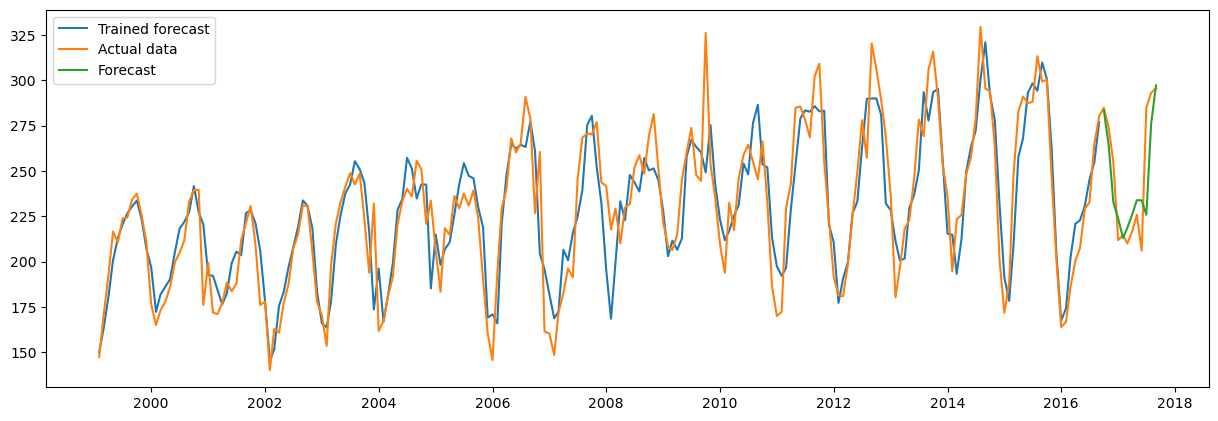

In [26]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

## CNN

In [27]:
def validate_cnn(train_X, train_y, val_X, val_y, epochs, filters, kernel_sizes, activations, second_filters):
    best_model, best_rmse, best_wmape, best_params = None, -np.Inf, -np.Inf, None
    for filter, kernel_size, activation, second_filter, epoch in product(filters, kernel_sizes, activations, second_filters, epochs):
        # reshape input to be 3D [samples, timesteps, features]

        train_x = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
        val_x = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))

        model_cnn = Sequential()
        model_cnn.add(Conv1D(filters=filter, kernel_size=kernel_size, activation=activation, 
                            input_shape=(train_x.shape[1], train_x.shape[2])))
        model_cnn.add(MaxPooling1D(pool_size=2))
        model_cnn.add(Flatten())
        model_cnn.add(Dense(second_filter, activation=activation))
        model_cnn.add(Dense(1))
        model_cnn.compile(loss='mse', optimizer='adam')

        model_cnn.fit(train_x, train_y, 
                        epochs=epoch, batch_size=64, 
                        validation_data=(val_x, val_y), 
                        verbose=2, shuffle=False)

        # make a prediction
        yhat = model_cnn.predict(val_x)
        yhat[yhat<0] = 0
        yhat_train = model_cnn.predict(train_x)
        yhat_train[yhat_train<0] = 0

        val_x = val_X.reshape((val_X.shape[0], val_X.shape[1]))
        train_x = train_X.reshape((train_X.shape[0], train_X.shape[1]))

        # invert scaling for training
        inv_yhat_train = np.concatenate((train_x, yhat_train), axis=1)
        inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
        inv_yhat_train = inv_yhat_train[:,-1]


        # invert scaling for forecast
        inv_yhat = np.concatenate((val_X, yhat), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = np.array(inv_yhat[:,-1])

        # invert scaling for actual
        val_y = val_y.reshape((len(val_y), 1))
        inv_y = np.concatenate((val_X, val_y), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = np.array(inv_y[:,-1])


        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        cur_rmse = np.sqrt(((inv_y - inv_yhat) ** 2).mean())

        cur_wmape = wmape(inv_y, inv_yhat)
        if abs(cur_rmse) < abs(best_rmse):
            best_model = model_cnn
            best_rmse = cur_rmse
            best_wmape = cur_wmape
            best_params = [filter, kernel_size, activation, second_filter, epoch]

    print("Best hyper-parameters:")
    print("filter: %i" % best_params[0], end="; ")
    print("kernel_size: %f" % best_params[1], end="; ")
    print("activation: %s" % best_params[2], end="; ")
    print("second_filter: %s" % best_params[3], end="; ")
    print("epoch: %s" % best_params[4])
    
    print("\nTrain data RMSE: %f; Train data WMAPE: %f" % (best_rmse, best_wmape))


In [29]:

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

val = train[-VALIDATION_SHIFT:, :]
train = train[:-VALIDATION_SHIFT, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]

validate_cnn(train_X, train_y, val_X, val_y,
        epochs=[100, 300, 600],
        filters=[64, 128, 256],
        kernel_sizes=[2, 8, 16],
        activations=['relu', 'sigmoid'], 
        second_filters=[40, 80, 120]
        )

Epoch 1/100
4/4 - 1s - loss: 0.2209 - val_loss: 0.0630 - 524ms/epoch - 131ms/step
Epoch 2/100
4/4 - 0s - loss: 0.0434 - val_loss: 0.0905 - 32ms/epoch - 8ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0514 - val_loss: 0.1443 - 31ms/epoch - 8ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0656 - val_loss: 0.1090 - 31ms/epoch - 8ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0469 - val_loss: 0.0731 - 34ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0355 - val_loss: 0.0557 - 34ms/epoch - 9ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0320 - val_loss: 0.0507 - 35ms/epoch - 9ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0298 - val_loss: 0.0523 - 32ms/epoch - 8ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0281 - val_loss: 0.0585 - 33ms/epoch - 8ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0283 - val_loss: 0.0642 - 33ms/epoch - 8ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0289 - val_loss: 0.0636 - 37ms/epoch - 9ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0276 - val_loss: 0.0566 - 33ms/epoch - 8ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0247 - val_los

Now, let's test the model with optimal hyperparameters on the test set that it hasn't seen yet:

Epoch 1/300
4/4 - 1s - loss: 0.0810 - val_loss: 0.0406 - 1s/epoch - 252ms/step
Epoch 2/300
4/4 - 0s - loss: 0.0514 - val_loss: 0.0547 - 54ms/epoch - 13ms/step
Epoch 3/300
4/4 - 0s - loss: 0.0401 - val_loss: 0.0377 - 78ms/epoch - 20ms/step
Epoch 4/300
4/4 - 0s - loss: 0.0189 - val_loss: 0.0111 - 79ms/epoch - 20ms/step
Epoch 5/300
4/4 - 0s - loss: 0.0251 - val_loss: 0.0147 - 84ms/epoch - 21ms/step
Epoch 6/300
4/4 - 0s - loss: 0.0188 - val_loss: 0.0283 - 82ms/epoch - 20ms/step
Epoch 7/300
4/4 - 0s - loss: 0.0156 - val_loss: 0.0126 - 72ms/epoch - 18ms/step
Epoch 8/300
4/4 - 0s - loss: 0.0145 - val_loss: 0.0101 - 81ms/epoch - 20ms/step
Epoch 9/300
4/4 - 0s - loss: 0.0142 - val_loss: 0.0189 - 78ms/epoch - 20ms/step
Epoch 10/300
4/4 - 0s - loss: 0.0129 - val_loss: 0.0156 - 79ms/epoch - 20ms/step
Epoch 11/300
4/4 - 0s - loss: 0.0114 - val_loss: 0.0133 - 78ms/epoch - 20ms/step
Epoch 12/300
4/4 - 0s - loss: 0.0114 - val_loss: 0.0178 - 84ms/epoch - 21ms/step
Epoch 13/300
4/4 - 0s - loss: 0.0106 -

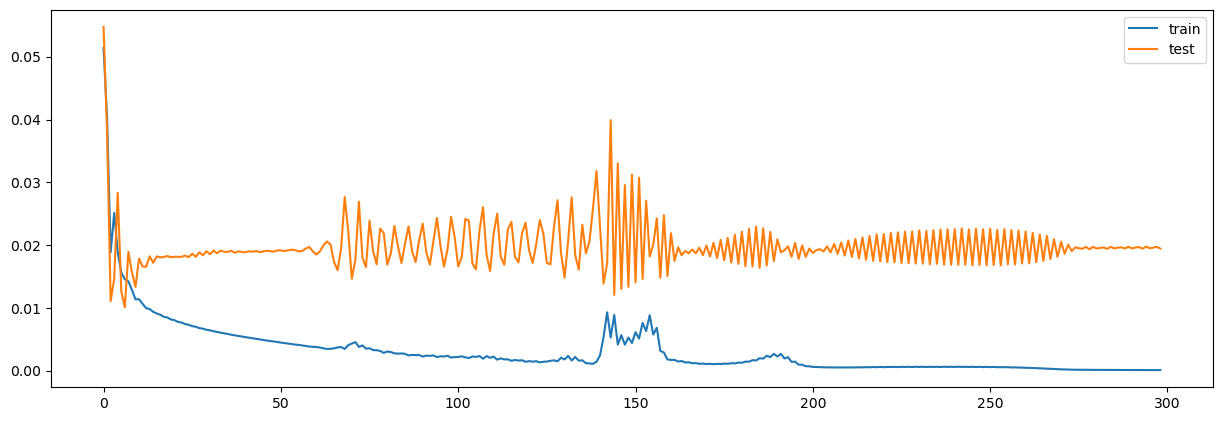

In [31]:
filters = 256
kernel_size = 8
activation = "relu"
second_filters = 40
epochs = 300

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(second_filters, activation=activation))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')

history = model_cnn.fit(train_X, train_y, 
                        epochs=epochs, batch_size=64, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model_cnn.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model_cnn.predict(train_X)
yhat_train[yhat_train<0] = 0

Test RMSE: 26.410
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [280.36804114 258.62650249 251.25133133 200.06829747 191.22784332
 204.82962599 202.78546758 215.45857902 237.28598865 225.44145596
 260.87244923 256.62223654]


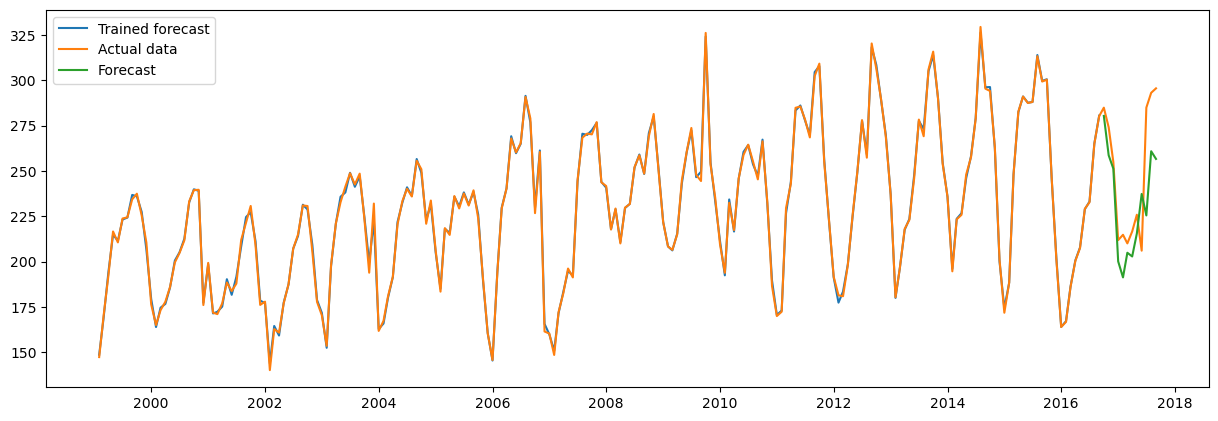

In [32]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))

# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

## Saving the best model to the disk

### From what we can observe, the best result was given by RNN model with the following parameters:
units = 10

epoch_num = 200

dropout = 0.02

activation = 'relu'

In [33]:
rnn_best.save("rnn_best")

INFO:tensorflow:Assets written to: rnn_best\assets
